# Nano-porous materials

In this notebook we'll explore nano-porous materials in the molecular dynamics scheme. We'll use Lammps to simulate our systems.

In [36]:
import os
import sys

sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from read_lammps_dump import read_dump
from read_lammps_log import read_log, get_temp_lognames

sns.set(color_codes=True)

We start by creating a system of liquid Argon in a system of $L = 20$ unit cells with length $b = 5.72 \text{Å}$ and thermalize it at $T = 0.851$. To create the specified length, we have to convert to the correct dimensions. For $\sigma = 3.405 \text{$\mu$m}$ we do this by
\begin{align}
    b' = \frac{b}{\sigma},
\end{align}
where $b'$ is the simulation length used in the simulation. When specifying the length in the front-centered-cubic lattice Lammps uses the reduced number density $\rho'$. This is given by
\begin{align}
    \rho' = \frac{n}{{b'}^3},
\end{align}
where $n$ is the number of atoms in the specified region. For front-centered-cubic lattices this is four atoms, i.e., $n = 4$.

Having set up the system we wish to thermalize it at $T = 0.851$ (note that the temperature is already in the right dimension). We do this by using the `fix nvt`-command in Lammps, which lets us specify the temperature we wish the system to achieve. Once the temperature desired temperature is achieved we move on to creating a cylinder, or in this case, we define a cylinder region and make all atoms outside this region frozen by removing all their velocity and keeping them fixed. Thus, all the atoms inside the cylinder still "feel" the atoms outside the cylinder, but they are unable to move the fixed atoms. The cylinder we create has a radius of $R = 2 \text{nm} = 20 \text{Å}$ and is located in the center of the $yz$-plane stretching from $x = 0$ to $x = L$.

In [3]:
%%writefile scripts/liquid_argon.in

# 3d Lennard-Jones gas
units lj
dimension 3
# Periodic boundiaries
boundary p p p
atom_style atomic

variable sigma equal 3.405
variable b equal 5.72
variable reduced_density equal 4/((${b}/${sigma})^3)
variable temperature equal 0.851

# Set fcc lattice with specified density
lattice fcc ${reduced_density}
region simbox block 0 20 0 20 0 20
create_box 2 simbox
create_atoms 1 box

# Use a radius of 2 nm (equal to 20 Å)
variable radius equal 20/${sigma}
variable centre_y equal ly/2
variable centre_z equal lz/2
region cylinder cylinder x ${centre_y} ${centre_z} ${radius} EDGE EDGE units box

mass * 1.0
velocity all create ${temperature} 87287

pair_style lj/cut 3.0
pair_coeff * * 1.0 1.0

fix 1 all nvt temp ${temperature} ${temperature} 0.5
#fix 1 all nve

thermo 100
# Thermalize for 3000 steps
run 300

# Group all atoms in the cylinder
group cylinder_group region cylinder
set group cylinder_group type 2
# Create another group from all the remaining atoms except for the ones in the cylinder
group frozen subtract all cylinder_group
# Set the velocity of the atoms outside the cylinder to zero
velocity frozen set 0 0 0
# Avoid integrating all the particles
unfix 1

# Run cylinder using nve
fix 1 cylinder_group nve

dump 1 all custom 10 dat/liquid_argon.lammpstrj id type x y z vx vy vz

run 5000

Overwriting scripts/liquid_argon.in


In [39]:
!export OMP_NUM_THREADS=4 && mpirun -np 4 lmp -in scripts/liquid_argon.in

LAMMPS (4 Jan 2019)
  using 4 OpenMP thread(s) per MPI task
Lattice spacing in x,y,z = 1.67988 1.67988 1.67988
Created orthogonal box = (0 0 0) to (33.5977 33.5977 33.5977)
  1 by 2 by 2 MPI processor grid
Created 32000 atoms
  Time spent = 0.000822122 secs
Created 0 atoms
  Time spent = 5.3607e-05 secs
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 3.3
  ghost atom cutoff = 3.3
  binsize = 1.65, bins = 21 21 21
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair lj/cut, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/3d/newton
      bin: standard
Setting up Verlet run ...
  Unit style    : lj
  Current step  : 0
  Time step     : 0.005
Per MPI rank memory allocation (min/avg/max) = 13.76 | 13.76 | 13.76 Mbytes
Step Temp E_pair E_mol TotEng Press 
       0        0.851   -6.9322187            0   -5.6557586 

In [27]:
%%writefile scripts/liquid_random_argon.in

# 3d Lennard-Jones gas
units lj
dimension 3
# Periodic boundiaries
boundary p p p
atom_style atomic

variable seed equal 87287
variable sigma equal 3.405
variable b equal 5.72
variable reduced_density equal 4/((${b}/${sigma})^3)
variable temperature equal 0.851
variable num_box equal 20
variable radius_min equal 20/${sigma}
variable radius_max equal 30/${sigma}

# Set fcc lattice with specified density
lattice fcc ${reduced_density}
region simbox block 0 ${num_box} 0 ${num_box} 0 ${num_box}
create_box 2 simbox
create_atoms 1 box

variable box_len equal lx

variable a loop 20
label pore_loop

variable x_1 equal random(0,${box_len},${seed})
variable y_1 equal random(0,${box_len},${seed})
variable z_1 equal random(0,${box_len},${seed})
variable radius_1 equal random(${radius_min},${radius_max},${seed})
region $a sphere ${x_1} ${y_1} ${z_1} ${radius_1} units box

next a
jump scripts/liquid_random_argon.in pore_loop

mass * 1.0
velocity all create ${temperature} ${seed}

pair_style lj/cut 3.0
pair_coeff * * 1.0 1.0

fix 1 all nvt temp ${temperature} ${temperature} 0.5
#fix 1 all nve

thermo 100
# Thermalize for 3000 steps
run 300

group pore_group region 1

# Group all atoms in the cylinder
variable a loop 2 20
label group_loop

group pore_$a region $a
group pore_group union pore_group pore_$a

next a
jump scripts/liquid_random_argon.in group_loop

set group pore_group type 2
# Create another group from all the remaining atoms except for the ones in the cylinder
group frozen subtract all pore_group
# Set the velocity of the atoms outside the cylinder to zero
velocity frozen set 0 0 0
# Avoid integrating all the particles
unfix 1

# Run cylinder using nve
fix 1 pore_group nve

dump 1 all custom 10 dat/liquid_random_argon.lammpstrj id type x y z vx vy vz

# Compute the porosity
variable porosity equal count(pore_group)/count(all)
print ${porosity} file dat/porosity.dat

run 1000

Overwriting scripts/liquid_random_argon.in


In [26]:
!export OMP_NUM_THREADS=4 && mpirun -np 4 lmp -in scripts/liquid_random_argon.in

LAMMPS (4 Jan 2019)
  using 4 OpenMP thread(s) per MPI task
Lattice spacing in x,y,z = 1.67988 1.67988 1.67988
Created orthogonal box = (0 0 0) to (33.5977 33.5977 33.5977)
  1 by 2 by 2 MPI processor grid
Created 32000 atoms
  Time spent = 0.000880943 secs
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 3.3
  ghost atom cutoff = 3.3
  binsize = 1.65, bins = 21 21 21
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair lj/cut, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/3d/newton
      bin: standard
Setting up Verlet run ...
  Unit style    : lj
  Current step  : 0
  Time step     : 0.005
Per MPI rank memory allocation (min/avg/max) = 11.78 | 11.78 | 11.78 Mbytes
Step Temp E_pair E_mol TotEng Press 
       0        0.851   -6.9322187            0   -5.6557586   -5.7920633 
     100   0.47402775   -6.319395

We measure the porosity of the system by counting all the particles that are moving, i.e., that belong to the pore groups, and divide by the total amount of particles in our simulation. That is, let $V_p$ be the fraction of porous media and $V$ be the total volume. Then the porosity is computed from
\begin{align}
    \phi = \frac{V_p}{V}.
\end{align}
In the simulation above we found $\phi \approx 0.54$. This is a higher porosity than we could achieve using non-overlapping pores. We can see this fact by considering a cube with sides $L = 9$ filled by non-overlapping spheres with radius $r = \frac{3}{2} = 1.5$. We are able to place $27$ such non-overlapping spheres in this cube filling it completely. The cube then has a volume $V_c = L^3 = 729$ and a single sphere consists of a volume $V_s = \frac{4}{3}\pi r^3 \approx 14.1$. The total volume of pore space is then
\begin{align}
    V_p = 27 V_s \approx 381.7,
\end{align}
yielding a porosity of
\begin{align}
    \phi = \frac{V_p}{V_c}
    \approx 0.52.
\end{align}

We now wish to look at a fluid in the pores with a temperature at $T = 1.5$ and with a lower density. We can use Lammps to delete a fraction of atoms in a group thus lowering the density.

In [66]:
%%writefile scripts/low_density.in

# 3d Lennard-Jones gas
units lj
dimension 3
# Periodic boundiaries
boundary p p p
atom_style atomic

variable seed equal 87287
variable sigma equal 3.405
variable b equal 5.72
variable reduced_density equal 4/((${b}/${sigma})^3)
variable temperature equal 1.5
variable num_box equal 20
variable radius_min equal 20/${sigma}
variable radius_max equal 30/${sigma}

# Set fcc lattice with specified density
lattice fcc ${reduced_density}
region simbox block 0 ${num_box} 0 ${num_box} 0 ${num_box}
create_box 2 simbox
create_atoms 1 box

variable box_len equal lx

mass * 1.0
velocity all create ${temperature} ${seed}

pair_style lj/cut 3.0
pair_coeff * * 1.0 1.0

fix 1 all nvt temp ${temperature} ${temperature} 0.5

thermo 100
run 1000

variable a loop 20
label pore_loop

variable x_1 equal random(0,${box_len},${seed})
variable y_1 equal random(0,${box_len},${seed})
variable z_1 equal random(0,${box_len},${seed})
variable radius_1 equal random(${radius_min},${radius_max},${seed})
region $a sphere ${x_1} ${y_1} ${z_1} ${radius_1} units box

# Delete half of the atoms in the region
delete_atoms porosity $a 0.5 ${seed}

next a
jump scripts/low_density.in pore_loop

# Create initial group
group pore_group region 1

# Group all atoms in the cylinder
variable a loop 2 20
label group_loop

group pore_$a region $a
group pore_group union pore_group pore_$a

next a
jump scripts/low_density.in group_loop

set group pore_group type 2
# Create another group from all the remaining atoms except for the ones in the cylinder
group frozen subtract all pore_group
# Set the velocity of the atoms outside the cylinder to zero
velocity frozen set 0 0 0
# Avoid integrating all the particles
unfix 1

# Thermalize pore_group
fix 1 pore_group nvt temp ${temperature} ${temperature} 0.5
thermo 100

run 1000

unfix 1
# Run pore_group using NVE
fix 1 pore_group nve

dump 1 all custom 10 dat/low_density.lammpstrj id type x y z vx vy vz

# Compute the porosity
variable porosity equal count(pore_group)/count(all)
print ${porosity} file dat/low_density_porosity.dat

reset_timestep 0
compute pore_temp pore_group temp
compute msd pore_group msd
variable time equal dt*step

thermo_style custom step v_time c_pore_temp etotal press c_msd[4]

thermo 10
log dat/low_density.log

run 2000

Overwriting scripts/low_density.in


In [67]:
!export OMP_NUM_THREADS=4 && mpirun -np 4 lmp -in scripts/low_density.in

LAMMPS (4 Jan 2019)
  using 4 OpenMP thread(s) per MPI task
Lattice spacing in x,y,z = 1.67988 1.67988 1.67988
Created orthogonal box = (0 0 0) to (33.5977 33.5977 33.5977)
  1 by 2 by 2 MPI processor grid
Created 32000 atoms
  Time spent = 0.00090625 secs
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 3.3
  ghost atom cutoff = 3.3
  binsize = 1.65, bins = 21 21 21
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair lj/cut, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/3d/newton
      bin: standard
Setting up Verlet run ...
  Unit style    : lj
  Current step  : 0
  Time step     : 0.005
Per MPI rank memory allocation (min/avg/max) = 11.78 | 11.78 | 11.78 Mbytes
Step Temp E_pair E_mol TotEng Press 
       0          1.5   -6.9322187            0    -4.682289   -5.2444747 
     100   0.83086252   -5.8374799

     170         0.85    1.5046377   -3.2571828    1.7902774    1.2804422 
     180          0.9    1.5123989    -3.257238    1.7827985    1.3814663 
     190         0.95    1.5104791   -3.2572633    1.7914411    1.4844902 
     200            1    1.5058932   -3.2572201    1.7999312    1.5887872 
     210         1.05    1.5082347   -3.2571693    1.7952639    1.6933597 
     220          1.1    1.5134662   -3.2571521    1.7898518    1.7985245 
     230         1.15    1.5160208   -3.2571914    1.7907028     1.904067 
     240          1.2    1.5119842   -3.2571497    1.7968724    2.0095174 
     250         1.25    1.5154226   -3.2572033    1.7899191    2.1147448 
     260          1.3    1.5152573     -3.25715    1.7909283     2.220157 
     270         1.35    1.5148428   -3.2571236    1.7926762    2.3259134 
     280          1.4    1.5139697   -3.2571245     1.791402    2.4328637 
     290         1.45    1.5093634   -3.2570674    1.7931523    2.5411493 
     300          1.5    

    1270         6.35    1.5037165   -3.2572203    1.7896964    12.796773 
    1280          6.4    1.5087057   -3.2571944    1.7835025    12.906468 
    1290         6.45    1.5042772   -3.2572082    1.7900286    13.017082 
    1300          6.5    1.4952287   -3.2572567    1.8002829      13.1273 
    1310         6.55    1.5040944   -3.2572847     1.783895    13.230084 
    1320          6.6    1.4958726   -3.2572453    1.7902982    13.327084 
    1330         6.65    1.5060686   -3.2572443    1.7728939    13.422581 
    1340          6.7    1.5073517   -3.2572631    1.7699044    13.521448 
    1350         6.75    1.5101778   -3.2572768    1.7676111    13.622271 
    1360          6.8    1.5088695    -3.257234    1.7730303    13.723976 
    1370         6.85    1.4993962   -3.2572666    1.7903535      13.8303 
    1380          6.9    1.4987512   -3.2573685    1.7942518    13.936931 
    1390         6.95    1.5028972   -3.2573675    1.7857354    14.041258 
    1400            7    

In [68]:
log_df = read_log("dat/low_density.log")

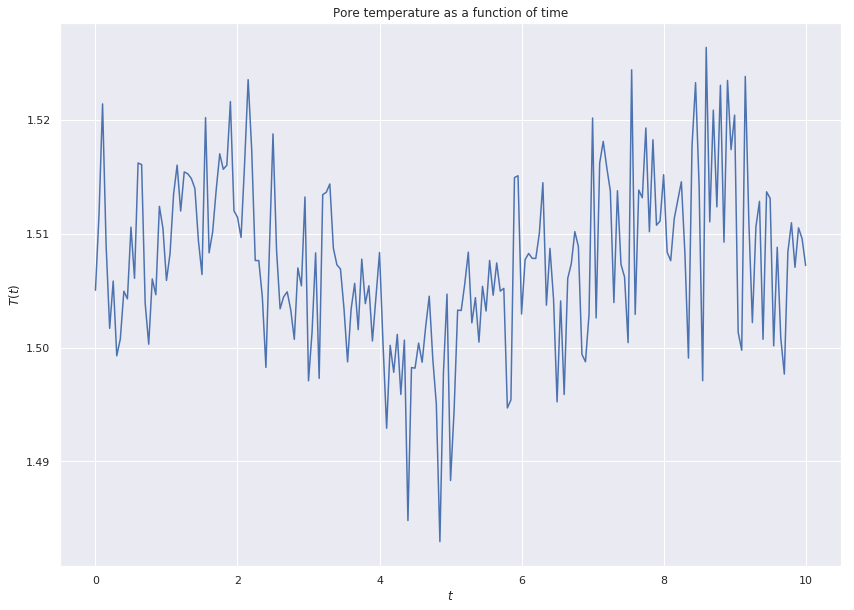

In [69]:
fig = plt.figure(figsize=(14, 10))

plt.plot(log_df["v_time"], log_df["c_pore_temp"])
plt.xlabel(r"$t$")
plt.ylabel(r"$T(t)$")
plt.title(r"Pore temperature as a function of time")
plt.show()

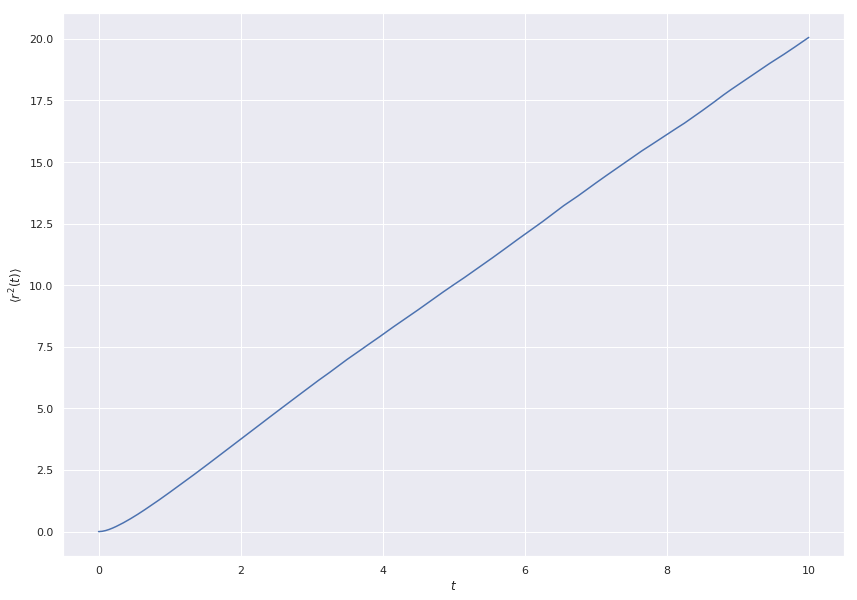

In [70]:
fig = plt.figure(figsize=(14, 10))

plt.plot(log_df["v_time"], log_df["c_msd[4]"])
plt.xlabel(r"$t$")
plt.ylabel(r"$\langle r^2(t) \rangle$")
plt.show()

Here we see how the mean squared displacement is linear when $t$ is large. Initially we observe the expected anomalous behaviour.